In [1]:
! pip install scikit-learn -Uqq

In [2]:
!git clone https://github.com/amueller/word_cloud.git
!cd word_cloud
!pip install .

Cloning into 'word_cloud'...
remote: Enumerating objects: 6544, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 6544 (delta 46), reused 91 (delta 38), pack-reused 6441
Receiving objects: 100% (6544/6544), 116.94 MiB | 20.88 MiB/s, done.
Resolving deltas: 100% (3877/3877), done.
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [135]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from google.colab import files
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

from nltk.corpus import stopwords as stpw
import nltk

from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

import pickle

## Load data
The final dataset to predict flowering and fruiting has 53799 records, which contains data from GBIF and HCNQ.

The field notes are in the column `Fieldnotes`

In [47]:
uploaded = files.upload()

Saving Allspecies_GBIF_HCNQ_fieldnotes_final.csv to Allspecies_GBIF_HCNQ_fieldnotes_final (2).csv


In [136]:
filename = "Allspecies_GBIF_HCNQ_fieldnotes_final.csv" # this must match the name of the file you uploaded
df = pd.read_csv(io.StringIO(uploaded[filename].decode("utf-8")))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53793 entries, 0 to 53792
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   gbifID                    46739 non-null  float64
 1   hcnqID                    7054 non-null   float64
 2   institutionCode           53606 non-null  object 
 3   recordedBy                52250 non-null  object 
 4   eventDate                 53792 non-null  object 
 5   year                      53792 non-null  float64
 6   month                     53793 non-null  float64
 7   day                       53286 non-null  float64
 8   Year_interval             53793 non-null  object 
 9   country                   53793 non-null  object 
 10  decimalLongitude          53793 non-null  float64
 11  Binned_longitude          37918 non-null  object 
 12  decimalLatitude           53793 non-null  float64
 13  Binned_latitude           53749 non-null  object 
 14  elevat

## Preprocessing of the field notes column


In [138]:
# Remove nan
df["FieldNotes"] = df["FieldNotes"].str.replace("nan","")

In [139]:
# Remove ca
df["FieldNotes"] = df["FieldNotes"].str.replace("ca","")

In [140]:
# Remove PORT US
df["FieldNotes"] = df["FieldNotes"].str.replace("PORT US","")

In [141]:
# Remove DSIPONIBLE
df["FieldNotes"] = df["FieldNotes"].str.replace("DISPONIBLE","")

In [142]:
# Remove punctuation and numbers
df['FieldNotes'] = df['FieldNotes'].str.replace('\d+', '')
df['FieldNotes'] = df['FieldNotes'].str.replace(r'[^\w\s]+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


## Exploratory data analysis

### Field notes

In [143]:
# Remove stop words of different languages
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [144]:
stop_words = stpw.words("french") + stpw.words("english") + stpw.words("spanish") + stpw.words("portuguese")

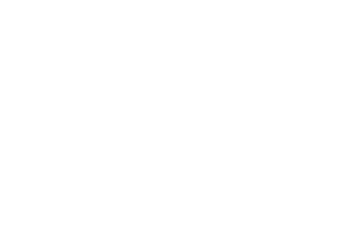

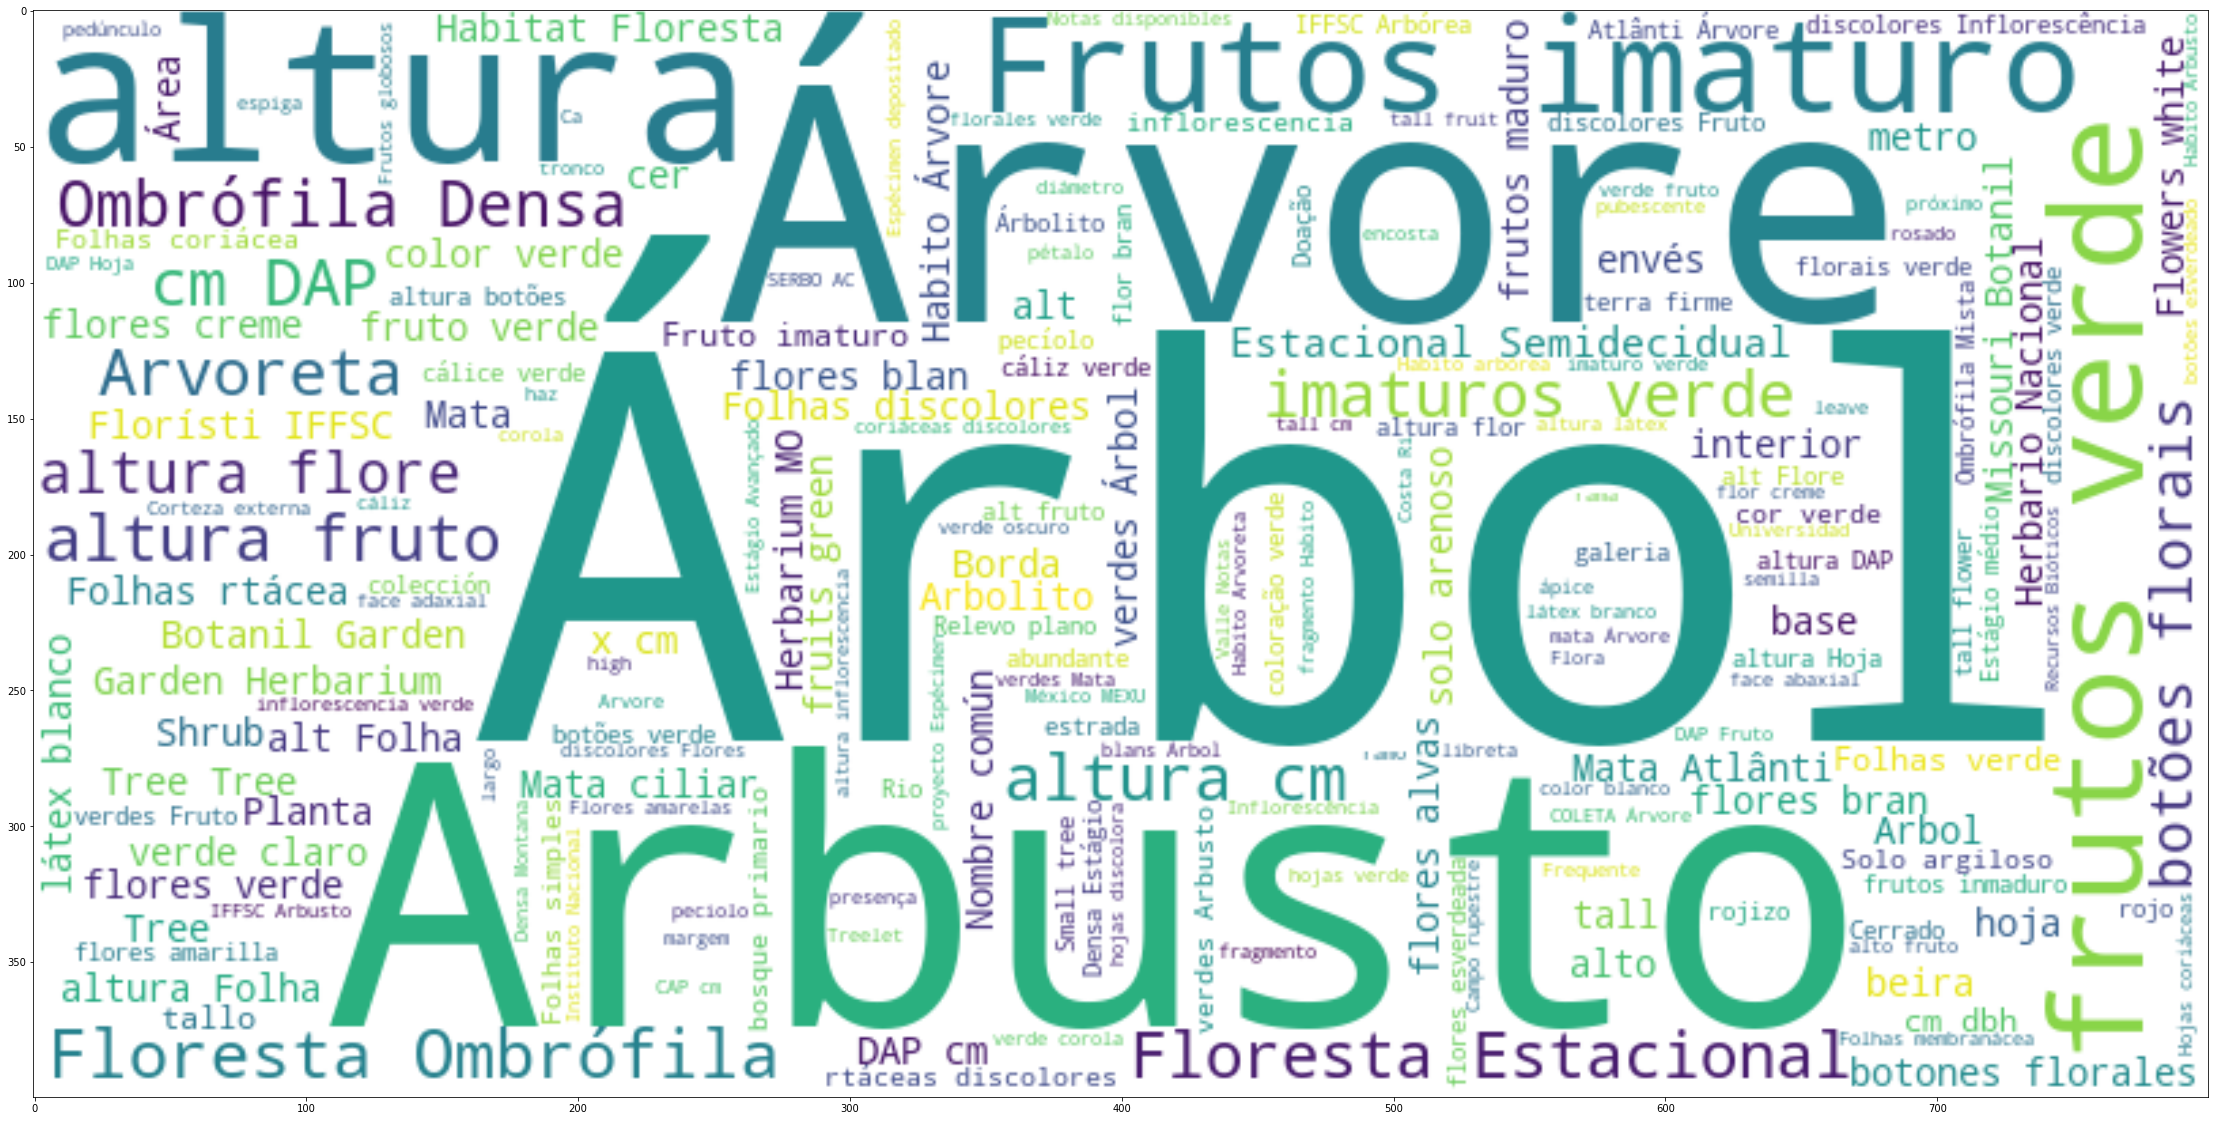

In [145]:
# WordCloud of field notes

# Text of all words in column bloom

text = " ".join(review for review in df.FieldNotes.astype(str))
#print ("There are {} words in the combination of all cells in column BLOOM.".format(len(text)))

# Create stopword list:
# remove words that we want to exclude
#stopwords.update(["bloom", "rose", "petals", "Average", "diameter","flushes", 'throughout', "Blooms", "form"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stop_words, background_color="white", width=800, height=400).generate(text)

# Display the generated image:
# the matplotlib way:

plt.axis("off")
plt.figure( figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [146]:
wordcloud.words_

{'Árbol': 1.0,
 'Arbusto': 0.9045454545454545,
 'Árvore': 0.8285353535353536,
 'altura': 0.7441919191919192,
 'Frutos imaturo': 0.5507575757575758,
 'frutos verde': 0.5292929292929293,
 'Floresta Ombrófila': 0.401010101010101,
 'imaturos verde': 0.37222222222222223,
 'altura cm': 0.36464646464646466,
 'cm DAP': 0.3573232323232323,
 'altura fruto': 0.3505050505050505,
 'Arvoreta': 0.34015151515151515,
 'Floresta Estacional': 0.326010101010101,
 'Ombrófila Densa': 0.296969696969697,
 'botões florais': 0.2532828282828283,
 'altura flore': 0.2457070707070707,
 'Estacional Semidecidual': 0.23762626262626263,
 'Mata': 0.21262626262626264,
 'Tree Tree': 0.21035353535353535,
 'DAP cm': 0.20959595959595959,
 'verde claro': 0.20176767676767676,
 'altura Folha': 0.19924242424242425,
 'Botanil Garden': 0.19772727272727272,
 'flores blan': 0.19747474747474747,
 'Mata Atlânti': 0.19494949494949496,
 'Shrub': 0.1898989898989899,
 'metro': 0.1898989898989899,
 'alt': 0.18787878787878787,
 'Tree': 0.17

## Predictions using rf models

Create the X and y variables for the RF models

In [147]:
# Define X for predictions
X = df['FieldNotes']

In [148]:
X

0                              Shrub  m tall flower yellow
1        Arbusto de  m de altura Hojas simples opuestas...
2             Arbusto de hasta  m de alto Flores amarillas
3                   Arbusto de  m de alto Flores amarillas
4        Steep slope sandy soil Shrub m Inflorescence a...
                               ...                        
53788                                                     
53789                                                     
53790                                                     
53791       Small tree m x cm Seasonally dry tropil forest
53792                                   Figuier étrangleur
Name: FieldNotes, Length: 53793, dtype: object

In [149]:
!ls

'Allspecies_GBIF_HCNQ_fieldnotes_final (1).csv'
'Allspecies_GBIF_HCNQ_fieldnotes_final (2).csv'
 Allspecies_GBIF_HCNQ_fieldnotes_final.csv
 RandomForest_flowering_nestimators100.bin
 RandomForest_fruiting_nestimators100.bin
 sample_data
 word_cloud


In [150]:
# Load Flowering RF model
model_file1 = 'RandomForest_flowering_nestimators100.bin'

with open(model_file1, 'rb') as f_in:
    rf_flow = pickle.load(f_in)

In [157]:
y_pred_flow# Make predictions for flowering
 = rf_flow.predict(X.apply(lambda x: np.str_(x)))

In [152]:
# Get the probability of predictions
y_pred_prob_flow = rf_flow.predict_proba(X.apply(lambda x: np.str_(x)))

In [159]:
# Add the predictions and prob as columns of df
df['Flowering_pred_RF'] = y_pred_flow
df['Flowering_pred_prob_RF'] = y_pred_prob_flow[:, 1]

In [161]:
df['Flowering_pred_RF'].value_counts()

No     36990
Yes    16803
Name: Flowering_pred_RF, dtype: int64

In [162]:
# Fruiting RF model
model_file2 = 'RandomForest_fruiting_nestimators100.bin'

with open(model_file2, 'rb') as f_in:
    rf_fruit = pickle.load(f_in)

In [163]:
# Make predictions for fruiting
y_pred_fruit = rf_fruit.predict(X.apply(lambda x: np.str_(x)))

In [164]:
# Get the probability of predictions
y_pred_prob_fruit = rf_fruit.predict_proba(X.apply(lambda x: np.str_(x)))

In [165]:
# Add the predictions and prob as columns of df
df['Fruiting_pred_RF'] = y_pred_fruit
df['Fruiting_pred_prob_RF'] = y_pred_prob_fruit[:, 1]

In [167]:
df['Fruiting_pred_RF'].value_counts()

No     40904
Yes    12889
Name: Fruiting_pred_RF, dtype: int64

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53793 entries, 0 to 53792
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   gbifID                    46739 non-null  float64
 1   hcnqID                    7054 non-null   float64
 2   institutionCode           53606 non-null  object 
 3   recordedBy                52250 non-null  object 
 4   eventDate                 53792 non-null  object 
 5   year                      53792 non-null  float64
 6   month                     53793 non-null  float64
 7   day                       53286 non-null  float64
 8   Year_interval             53793 non-null  object 
 9   country                   53793 non-null  object 
 10  decimalLongitude          53793 non-null  float64
 11  Binned_longitude          37918 non-null  object 
 12  decimalLatitude           53793 non-null  float64
 13  Binned_latitude           53749 non-null  object 
 14  elevat

In [169]:
df.head(10)

,gbifID,hcnqID,institutionCode,recordedBy,eventDate,year,month,day,Year_interval,country,...,n_records,nrecords_interval,occurrenceRemarks,dynamicProperties,fieldNotes,FieldNotes,Flowering_pred_RF,Flowering_pred_prob_RF,Fruiting_pred_RF,Fruiting_pred_prob_RF
0,NaN,81150.0,INABIOEC,Thomas Bernard Croat,3/23/2006,2006.0,3.0,23.0,1970-2010,Ecuador,...,15.0,11-100,NaN,NaN,Shrub 3 m tall; flower yellow.,Shrub m tall flower yellow,Yes,0.740000,No,0.364
1,NaN,81298.0,INABIOEC,Aída Álvarez,5/1/1992,1992.0,5.0,1.0,1970-2010,Ecuador,...,15.0,11-100,NaN,NaN,"Arbusto de 2 m de altura. Hojas simples, opues...",Arbusto de m de altura Hojas simples opuestas...,Yes,0.910000,No,0.070
2,NaN,146256.0,INABIOEC,Diego Reyes,10/26/2008,2008.0,10.0,26.0,1970-2010,Ecuador,...,15.0,11-100,NaN,NaN,Arbusto de hasta 3 m de alto. Flores amarillas.,Arbusto de hasta m de alto Flores amarillas,Yes,0.950000,No,0.010
3,NaN,150837.0,INABIOEC,H. Anton,1/12/1997,1997.0,1.0,12.0,1970-2010,Ecuador,...,15.0,11-100,NaN,NaN,Arbusto de 3 m de alto. Flores amarillas.,Arbusto de m de alto Flores amarillas,Yes,0.950000,No,0.010
4,NaN,151015.0,INABIOEC,R. Pennington,1/15/1997,1997.0,1.0,15.0,1970-2010,Ecuador,...,15.0,11-100,NaN,NaN,"Steep slope, sandy soil. Shrub 4m. Inflorescen...",Steep slope sandy soil Shrub m Inflorescence a...,Yes,0.990000,No,0.180
5,NaN,5525.0,INABIOEC,Calaway Homer Dodson,1979-07-12,1979.0,7.0,12.0,1970-2010,Ecuador,...,133.0,101-500,NaN,NaN,"Tree to 8 m along river bank. Petals white, st...",Tree to m along river bank Petals white stame...,Yes,0.940000,No,0.035
6,NaN,7035.0,INABIOEC,Fernando Nicolalde-Morejón,1999-10-19,1999.0,10.0,19.0,1970-2010,Ecuador,...,133.0,101-500,NaN,NaN,Árbol de 6 m. Flores blancas. Estambres amaril...,Árbol de m Flores blans Estambres amarillas,Yes,0.995897,No,0.000
7,NaN,8051.0,INABIOEC,Milton Tirado,1994-08-18,1994.0,8.0,18.0,1970-2010,Ecuador,...,133.0,101-500,NaN,NaN,Árbol de 18-20 m de altura. Flores blancas. No...,Árbol de m de altura Flores blans Nombre comú...,Yes,0.946374,No,0.080
8,NaN,139050.0,INABIOEC,Laurence Joseph Dorr,1988-11-14,1988.0,11.0,14.0,1970-2010,Ecuador,...,133.0,101-500,NaN,NaN,"Tree, 5 m tall petal white. Anthers yellow. Ov...",Tree m tall petal white Anthers yellow Ovary ...,Yes,0.916667,No,0.230
9,NaN,139051.0,INABIOEC,Efraín Liborio Freire Mayorga,2007-05-07,2007.0,5.0,7.0,1970-2010,Ecuador,...,133.0,101-500,NaN,NaN,"Árbol con inflorescencia apical, flores blancas",Árbol con inflorescencia apil flores blans,Yes,0.981040,No,0.000


In [170]:
# Export the final dataset
df.to_csv('Allspecies_GBIF_HCNQ_fieldnotes_RF_predictions.csv', index=False)